# Gibbs Sampling 
Gibbs Sampling updates each component of the state by sampling from its conditional distribution given other components
This method can eliminate or reduce the need for "tuning" of a proposal distribution.

Gibbs sampling is a MCMC algorithm that repeatedly samples from the conditional distribution of one variable of the target distribution p, given all other variables. It assumes we can compute conditional distributions of one variable conditioned on all of other variables and sample exactly from these distributions.

## Gibbs Sampling for Bayesian Linear Regression


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
plt.rcParams['figure.figsize'] = (10, 5)

Fontconfig error: Cannot load default config file: No such file: (null)


# Steps to derive a Gibbs Sampler
1. Write down posterior conditional density
2. Eliminate variables that do not depend on the current sampling variable
3. Assume that density of interest variable and all other variable are fixed. 
4. Find the distribution of posterior conditional density

## Step 1 : Calculate $\beta_0$ and  $\beta_1$

In [5]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    precision = tau_0 + tau * len(y)
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [6]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [7]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    alpha_new = alpha + len(y) / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    
    return np.random.gamma(alpha_new, 1 / beta_new)

## Step 2: Sample Synthetic Data

Text(0, 0.5, 'y')

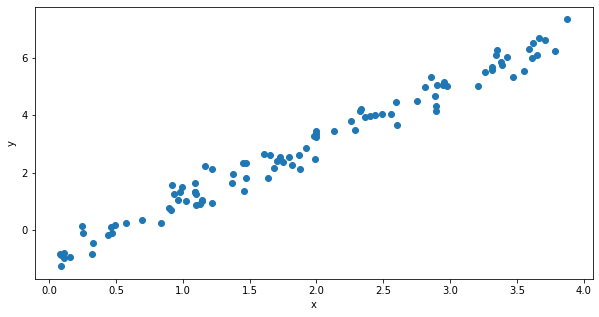

In [8]:
beta_0_true = -1
beta_1_true = 2
tau_true = 10

N = 100
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))


synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")

## Step 3: Write Gibbs Sampler

In [9]:
## specify initial values
init = {"beta_0": 0,
        "beta_1": 0,
        "tau": 2}

## specify hyper parameters
hypers = {"mu_0": 0,
         "tau_0": 1,
         "mu_1": 0,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}

In [10]:
def gibbs(y, x, iters, init, hypers):
    
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace


## Plotting Data

In [11]:
iters = 10000
trace = gibbs(y, x, iters, init, hypers)
tau_sample = gibbs(y, x, iters, init, hypers)["tau"]
beta_0_sample = gibbs(y, x, iters, init, hypers)["beta_0"]
beta_1_sample = gibbs(y, x, iters, init, hypers)["beta_1"]

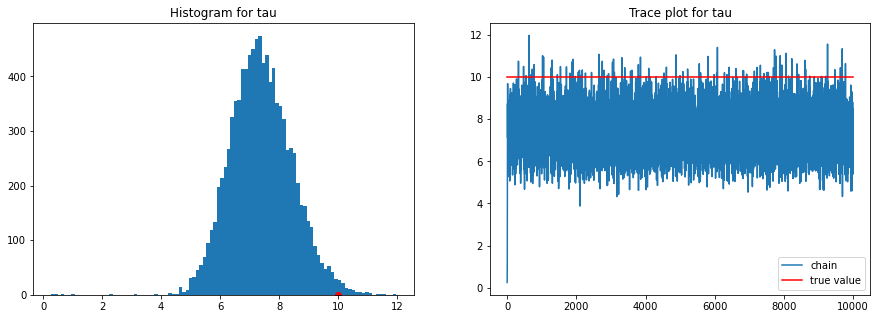

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(tau_sample, bins=100)
plt.scatter(tau_true, 0, c="r")
plt.title("Histogram for tau")
plt.subplot(1,2,2)
plt.plot(tau_sample, label="chain")
plt.plot([0, len(tau_sample)], [tau_true, tau_true], c="r", label="true value")
plt.title("Trace plot for tau")
plt.legend()
plt.show()

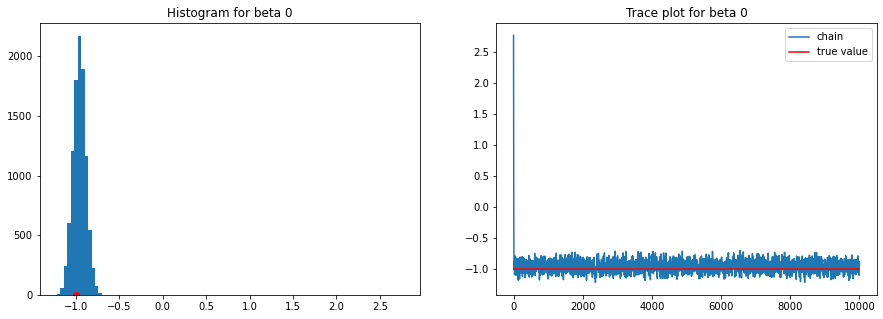

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(beta_0_sample, bins=100)
plt.scatter(beta_0_true, 0, c="r")
plt.title("Histogram for beta 0")
plt.subplot(1,2,2)
plt.plot(beta_0_sample, label="chain")
plt.plot([0, len(beta_0_sample)], [beta_0_true, beta_0_true], c="r", label="true value")
plt.title("Trace plot for beta 0")
plt.legend()
plt.show()

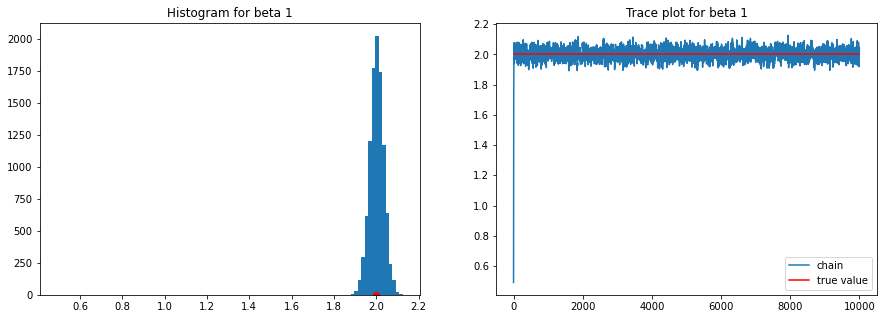

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(beta_1_sample, bins=100)
plt.scatter(beta_1_true, 0, c="r")
plt.title("Histogram for beta 1")
plt.subplot(1,2,2)
plt.plot(beta_1_sample, label="chain")
plt.plot([0, len(beta_1_sample)], [beta_1_true, beta_1_true], c="r", label="true value")
plt.title("Trace plot for beta 1")
plt.legend()
plt.show()

Text(0, 0.5, 'Parameter value')

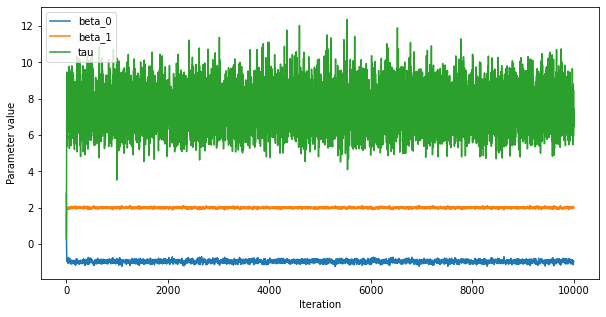

In [15]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

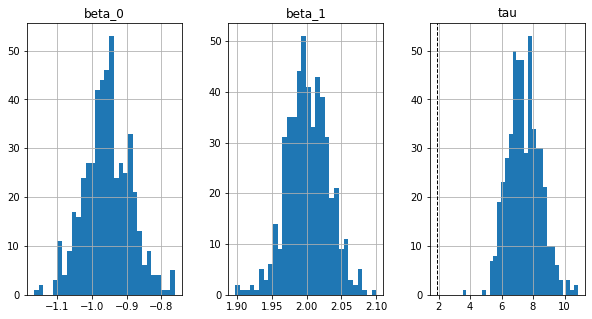

In [16]:
trace_burnt = trace[500:999]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)

In [17]:
print(trace_burnt.median())
print(trace_burnt.mean())
print(trace_burnt.std())

beta_0   -0.957825
beta_1    1.999967
tau       7.333903
dtype: float64
beta_0   -0.956433
beta_1    2.001608
tau       7.423022
dtype: float64
beta_0    0.067216
beta_1    0.030253
tau       1.025713
dtype: float64


## Gibbs Sampling for Multivarative Linear Regression


### Step 1 : Simulate Data
- Sample data from model 
- Construct the matrix X, vector y and theta

In [184]:
def simulate_data(w, b, sigma, N, design_range = (-10,10)):
        designs = np.random.uniform(design_range[0], design_range[1], size=(N, w.size))
        theta = np.expand_dims(np.concatenate([w, [b]], axis=0), axis=1)
        X = np.concatenate([designs, np.ones((N, 1))], axis=1)
        y_mean = (X @ theta).squeeze()
        y = np.random.multivariate_normal(mean=y_mean, cov=np.diag([sigma**2] * N))
        
        return X,y
        
        
def plot_data(w, b, X, design_range = (-10,10)):
        # Plot data
        X,y = simulate_data(w, b, sigma = 5, N = 200, design_range = (-10,10))
        x = X[:, 0]
        plt.scatter(x, y, label="data")
        x_dense = np.linspace(design_range[0], design_range[1], 100)
        y_dense = x_dense * w[0] + b
        plt.plot(x_dense, y_dense, label="y mean")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Simulated data, N="+str(N))
        plt.show()


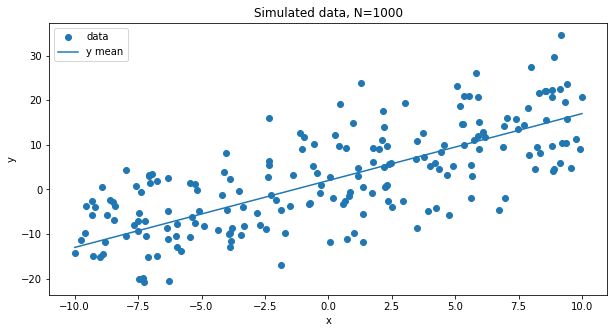

In [185]:
# True weight(s)
w = np.array([1.5, -1.0, 0.7])

# Input dimensionality
d = w.size

# True intercept
b = 2.0

# True standard deviation
sigma = 1

# Number of data points
N = 1000


X,y = simulate_data(w, b, sigma, N, design_range = (-10,10))
plot_data(w, b, X, design_range = (-10,10))

### Step 2 : Define priors

In [186]:
# Define priors
alpha_0 = 0.0001
beta_0 = 0.0001
#sigma_0 = 10

## Step 3: Initialize chain
- Initialize precision gamma and parameter theta
- Draw sample from the posteriors

In [187]:
gamma = 1
# Define theta as a vector with zeros
theta = np.zeros(d+1)

M = 5

# Number of samples per chain
N = 7000

# Total number of parameters in the model
P = d + 2

# Initialize samples array
samples = np.zeros((N,P))

In [188]:
# Draw T samples from the posterior
T = 200
#designs = np.random.uniform(-10, 10, size=(N, w.size))


for i in range(N):
    # Compute the parameters for gamma distribution from which we sample tau
    alpha = alpha_0 + N/2
    
    z = y - X @  theta
    
    beta = beta_0 + 0.5 * z.T @ z

    # Sample tau
    tau_samples = np.random.gamma(alpha, 1/beta)
    

    # Compute the parameters for the normal distribution from which we sample theta
    A = tau_samples * X.T @ X 
    b = tau_samples * X.T @ y
    mu = np.linalg.solve(A, b)
    Sigma = np.linalg.inv(A)

    # Sample theta
    theta = np.random.multivariate_normal(mu, Sigma)
    

    # Store within chain samples
    samples[i, 0] = tau_samples
    samples[i, 1:] = theta
    
# TODO: Try to use formula we derived in last session for A, B, Sigma, mu

In [189]:
samples

array([[ 0.05826901,  1.45543971, -0.96841193,  0.70178011,  1.90698868],
       [ 6.12000841,  1.50144169, -0.9912692 ,  0.69528935,  2.02565971],
       [ 6.78143213,  1.49674949, -0.99427396,  0.69285396,  2.02446999],
       ...,
       [ 6.54335379,  1.49782493, -0.99266983,  0.69631222,  2.02297385],
       [ 6.72763813,  1.49965899, -0.98919681,  0.69471821,  2.03402378],
       [ 6.33473628,  1.49997893, -0.99079344,  0.69858917,  2.04273085]])

## Step 4: Analayze the chain


In [190]:
# Analyse sigma samples

sigma_samples = samples[100:,1]
#sigma_est = (1/np.sqrt(sigma_samples)).mean()
sigma_est = sigma_samples.mean()

print("Estimated sigma ", sigma_est)
print("True sigma:",w[0])

# Calculate mean square error
from sklearn.metrics import mean_squared_error

mse = mean_squared_error([sigma_est], [sigma])
print("Mean Square Error for Sigma: ", mse)

Estimated sigma  1.5008296271783828
True sigma: 1.5
Mean Square Error for Sigma:  0.25083031545963785


In [191]:
# Analyse theta samples

theta_samples = samples[100:,2]
#sigma_est = (1/np.sqrt(sigma_samples)).mean()
theta_est = theta_samples.mean()

print("Estimated theta ", theta_est)
print("True theta:",w[1])

# Calculate mean square error
from sklearn.metrics import mean_squared_error

mse = mean_squared_error([sigma_est], [sigma])
print("Mean Square Error for Theta: ", mse)

Estimated sigma  -0.992642977820687
True sigma: -1.0
Mean Square Error for Sigma:  3.9706260370580955


In [101]:
# Analyse tau samples

In [198]:
def compute_psrf(samples):
    
    """
    param samples: 3 dimensional numpy array of shape (M, N, P)
    returns: R-hat values for each model parameter
    """
    M, N, P = samples.shape
    
    within_chain_means = samples.mean(axis=1)
    within_chain_vars = samples.var(axis=1)
    between_chain_means = samples.mean(axis=(0, 1))
    
    B = N * ((within_chain_means - between_chain_means) ** 2).sum(axis=(0)) / (M - 1)
    
    W = within_chain_vars.mean(axis=0)
    
    V = (N - 1) * W / N + (M + 1) * B / (M * N)
    
    psrf = np.sqrt(V / W)
    
    return psrf

In [199]:
# Add library path
import sys
sys.path.append('/MCMC/mcmc-project/')

#from psrf import compute_psrf

psrf = compute_psrf(samples)

print("PSRF values: {}".format(psrf))

# Check that all model parameters have converged
convergence_threshold = 1.1
if (psrf < convergence_threshold).all():
    print("Convergence test passed.")

ValueError: not enough values to unpack (expected 3, got 2)